# 0. Parsing raw form

In [1]:
import json

In [2]:
from cancer_nutrition.utils.db.frontend import DBProvider
from cancer_nutrition.utils.constants.db import *
from cancer_nutrition.utils.form.form import form_to_dict

In [3]:
fpath = "/Users/andreyignatov/Downloads/test-1689660250.4450483.json"
# fpath = "/Users/andreyignatov/Downloads/test-1689066441.0527298.json"

with open(fpath) as f:
    form_dict_str = f.read()
    form_dict_str = form_dict_str.replace("ImmutableMultiDict(", "")[:-1]
    form_dict_str = form_dict_str.replace("(", "[").replace(")", "]").replace("'", "\"")
    
    form_dict = {k: v for (k,v) in json.loads(form_dict_str)}

In [4]:
db_provider = DBProvider(DB_NAME, DB_USER, DB_PASSWD, DB_HOST, 11459)

In [5]:
data_config = db_provider.get_data_config()

In [6]:
from cancer_nutrition.utils.value import str_is_unit, Value, Analysis
from datetime import date

# 1. Getting patient info

In [7]:
from cancer_nutrition.patient import PatientInfo

In [8]:
form_dict["1^7"] = "test"
form_dict["1^8"] = "test"


In [9]:
form_patient_info = form_to_dict(form_dict, data_config)

In [10]:
from cancer_nutrition.utils.age import Age

In [11]:
patient_info = PatientInfo(form_patient_info, db_provider)

1it [00:01,  1.83s/it]


In [12]:
len(patient_info.data)

1

In [32]:
# import numpy as np


# np.save("./data_config.npy", data_config, allow_pickle=True)

# 2. Получение рекомендаций

In [14]:
from cancer_nutrition.nutrition.main import NutritionRecommender, ProteinDerivation, CarbohydrateDerivation, LipidDerivation, EnergyDerivation


In [15]:
recommender = NutritionRecommender(patient_info, db_provider)

In [118]:
# patient_info.data[0]["Доля парентерального питания"] = 0

In [16]:
recom_sets = recommender.get_recommendations()

{'Белок': {'value': 1.0, 'limits': [0.5, 1.0], 'due': 2.0}, 'Жиры': {'value': 1.0, 'limits': [0.0, 1.0], 'due': 3.0}, 'Углеводы': {'value': 11.3, 'limits': [8.6, 11.3], 'due': 14.0}, 'ККал': {'value': 527.09688, 'limits': [0, inf], 'due': 1317.7422000000001}} {'Белок_due': 2.0, 'Жиры_due': 3.0, 'Углеводы_due': 14.0, 'ККал_due': 1317.7422000000001}


In [19]:
recom_sets[0].get_recommendations()

{'Производные параметры': {'ИМТ': 11.562030292519365,
  'z-score роста': -2.46236631053403,
  'z-score массы тела': -3.841562607526336,
  'z-score ИМТ': -3.5589128366023974,
  'Нормальный нутритивный статус': False,
  'Легкая белково-энергетическая недостаточность': False,
  'Умеренная белково-энергетическая недостаточность': False,
  'Тяжелая белково-энергетическая недостаточность': True,
  'Избыточная масса тела': False,
  'Ожирение 1 степени': False,
  'Ожирение 2 степени': False,
  'Ожирение 3 степени': False,
  'Ожирение тяжелое': False,
  'Дефицит висцерального пула белка': True,
  'Тек*Небелковые ккал': 0,
  'СКФ': 86.44004571428572,
  'Острая печеночная недостаточность': True,
  'Лабораторные признаки холестаза': 0.0,
  'Острое повреждение почек': 0,
  'Лабораторные признаки острого панкреатита': 0,
  'Ожидаемая токсичность': 0,
  'Идеальная масса тела': None,
  'Риск рефидинг-синдрома': 1},
 'Доли': {'сипинг': '50.0 %', 'зонд': '0.0 %', 'ПЭП': '100.0 %'},
 'сипинг': {'Назначен

In [21]:
from cancer_nutrition.nutrition.parenteral_selection import ParenteralSelector
from numpy import inf

In [17]:
from pulp import LpProblem, LpVariable, LpStatus, LpMinimize, lpSum

_BALANCE_FUNCTION_COEFF = 0.5


In [22]:
demands = {'Белок': {'value': 1.0, 'limits': [0.5, 1.0], 'due': 2.0}, 'Жиры': {'value': 1.0, 'limits': [0.0, 1.0], 'due': 3.0}, 'Углеводы': {'value': 11.3, 'limits': [8.6, 11.3], 'due': 14.0}, 'ККал': {'value': 527.09688, 'limits': [0, inf], 'due': 1317.7422000000001}}
patient = patient_info.data[0]


_prob = ParenteralSelector._make_balance_problem(demands,
                                         patient["fractions"]["ПЭП"],
                                         # patient["Полное восполнение питания"],
                                         patient_info.data[0]["ПЭП"],
                                         patient["Масса тела"]["кг"] if patient["Идеальная масса тела"] is None else
                                         patient["Идеальная масса тела"]["кг"],
                                         patient["Возраст"]["лет"],
                                         patient[
                                             "Наличие центрального венозного катетера (либо будет установлен в ближайшие 48 часов)"],
                                         None, 1)


KeyError: 'fractions'

In [20]:
ParenteralSelector.compute(patient, demands, patient["ПЭП"])

({'P': 1.0, 'L': 1.0, 'C': 11.3},
 {'Оликлиномель N7': 250, 'Глюкоза 20%': 360, 'Глюкоза 40%': 0})

In [22]:
_prob.solve()

{k: v.value() for k,v in _prob.variablesDict().items()}

{'abs_plc_delta': 0.0,
 'n_nutritions': 1.0,
 'cvk_selection': -3.0,
 'can_take_nogluk_nocomb': 0.0,
 'L': 1.0,
 'C': 11.3,
 'P': 1.0,
 'xv_0': 2.5,
 'xv_1': 0.0,
 'xv_6': 0.0,
 'xv_7': 0.0,
 'xv_8': 0.0,
 'xv_9': 0.0,
 'xv_11': 0.0,
 'xv_12': 0.0,
 'xv_13': 0.0,
 'xv_14': 0.0,
 'xv_15': 0.0,
 'xv_16': 0.0,
 'xv_17': 0.0,
 'xv_18': 0.0,
 'xv_19': 0.0,
 'xv_20': 0.0,
 'xv_21': 0.0,
 'xv_22': 0.0,
 'xv_10': 0.0,
 'xv_2': 0.0,
 'xv_3': 0.0,
 'xv_4': 3.65,
 'xv_5': 0.0,
 'x_0': 1.0,
 'x_1': 0.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 1.0,
 'x_5': 1.0,
 'x_6': 0.0,
 'x_7': 0.0,
 'x_8': 0.0,
 'x_9': 0.0,
 'x_10': 0.0,
 'x_11': 0.0,
 'x_12': 0.0,
 'x_13': 0.0,
 'x_14': 0.0,
 'x_15': 0.0,
 'x_16': 0.0,
 'x_17': 0.0,
 'x_18': 0.0,
 'x_19': 0.0,
 'x_20': 0.0,
 'x_21': 0.0,
 'x_22': 0.0,
 'mp': 0.0,
 'ml': 0.0,
 'mc': 0.0,
 'total_volume': 6.15}

In [15]:
parenterals = patient_info.data[0]["ПЭП"]
parenterals["Аминовен 10%"]["Комбинированный"] = 0
parenterals["Аминовен инфант 10%"]["Комбинированный"] = 0
parenterals["Аминоплазмаль гепа 10%"]["Комбинированный"] = 0
parenterals["Глюкоза 10%"]["Комбинированный"] = 0
parenterals["Глюкоза 20%"]["Комбинированный"] = 0
parenterals["Глюкоза 40%"]["Комбинированный"] = 0
parenterals["Глюкоза 5%"]["Комбинированный"] = 0
parenterals["Кабивен периферический"]["Комбинированный"] = 1
parenterals["Кабивен центральный"]["Комбинированный"] = 1
parenterals["Кабивен центральный без жиров"]["Комбинированный"] = 1
parenterals["Нефротект 10%"]["Комбинированный"] = 0
parenterals["Нутрифлекс 40/80 липид"]["Комбинированный"] = 1
parenterals["Нутрифлекс 48/150 липид"]["Комбинированный"] = 1
parenterals["Нутрифлекс 70/180 без жиров"]["Комбинированный"] = 1
parenterals["Нутрифлекс 70/180 липид"]["Комбинированный"] = 1
parenterals["Нутрифлекс 70/240"]["Комбинированный"] = 1
parenterals["Оликлиномель N7"]["Комбинированный"] = 1
parenterals["Оликлиномель N7 без жиров"]["Комбинированный"] = 1
parenterals["СМОФ Кабивен периф. Без жир."]["Комбинированный"] = 1
parenterals["СМОФ Кабивен периферический"]["Комбинированный"] = 1
parenterals["СМОФ Кабивен центральный"]["Комбинированный"] = 1
parenterals["СМОФ Кабивен центральный без жиров"]["Комбинированный"] = 1
parenterals["СМОФЛипид 20%"]["Комбинированный"] = 0
parenterals["Аминоплазмаль гепа 10%"]["Гепа"] = 1
parenterals["Нефротект 10%"]["Нефро"] = 1

In [25]:
NutritionTypeFractions.compute(demands, **patient)

{'сипинг': 0.5, 'зонд': 0.0, 'ПЭП': 1.0}

In [120]:
# demands = {'Белок': {'value': 1.5, 'limits': [1.0, 1.5], 'due': 1.5}, 'Жиры': {'value': 1.5, 'limits': [0.0, 1.5], 'due': 1.5}, 'Углеводы': {'value': 5.05, 'limits': [4.3, 5.05], 'due': 5.05}, 'ККал': {'value': 1953.7952000000005, 'limits': [0, inf], 'due': 1953.7952000000002}}

demands = {'Белок': {'value': 1.0, 'limits': [0.5, 1.0], 'due': 2.0}, 'Жиры': {'value': 1.0, 'limits': [0.0, 1.0], 'due': 3.0}, 'Углеводы': {'value': 11.3, 'limits': [8.6, 11.3], 'due': 14.0}, 'ККал': {'value': 527.09688, 'limits': [0, inf], 'due': 1317.7422000000001}}


In [121]:
prob = LpProblem("pen2", LpMinimize)

patient = patient_info.data[0]
patient["fractions"] = {'сипинг': 0.5, 'зонд': 0.0, 'ПЭП': 1.0} # NutritionTypeFractions.compute(demands, **patient)

anamnesis = {k: patient[k] for k in
             ["Острое повреждение почек", "Хроническая болезнь почек", "Острая печеночная недостаточность"]}

cvc = patient["Наличие центрального венозного катетера (либо будет установлен в ближайшие 48 часов)"]
age_years = patient["Возраст"]["лет"]
m = patient["Масса тела"]["кг"]
disabled = None
full_problem = 1

M = 1e7
Mm = 1e-1

P = LpVariable("P",
               lowBound=demands["Белок"]["limits"][0],
               upBound=demands["Белок"]["limits"][1])
L = LpVariable("L",
               lowBound=demands["Жиры"]["limits"][0],
               upBound=demands["Жиры"]["limits"][1])
C = LpVariable("C",
               lowBound=demands["Углеводы"]["limits"][0],
               upBound=demands["Углеводы"]["limits"][1])

# i'th parenteral chosen or not
xs = LpVariable.dicts("x",
                      (i for i in range(len(parenterals))),
                      cat="Binary")
ent_doses = LpVariable.dicts("xv",
                             (i for i in range(len(parenterals))),
                             cat="Continuous",
                             lowBound=0)


prob += 9 * L + 4 * C >= P * (20 + 5 * (patient["fractions"]["ПЭП"] if full_problem else 0))

for i, (par_name, par) in enumerate(parenterals.items()):
    prob += ent_doses[i] <= xs[i] * M
    prob += ent_doses[i] >= Mm * xs[i]
    
    if cvc == 0 and par["ЦВК"] == 1:
        prob += xs[i] == 0
    if age_years < par["Возраст"]:
        prob += xs[i] == 0
    if disabled is not None and par_name in disabled:
        prob += xs[i] == 0
    
mp, ml, mc = LpVariable("mp"), LpVariable("ml"), LpVariable("mc")
f1, f2 = LpVariable("abs_plc_delta"), LpVariable("n_nutritions")
f3, f4 = LpVariable("cvk_selection"), LpVariable("total_volume")

# уход от модуля в целевой функции.
# (для объяснений - см. примеры с семинаров по Методам Оптимизации)
prob += mp >= P - demands["Белок"]["value"]
prob += mp >= demands["Белок"]["value"] - P
prob += ml >= L - demands["Жиры"]["value"]
prob += ml >= demands["Жиры"]["value"] - L
prob += mc >= C - demands["Углеводы"]["value"]
prob += mc >= demands["Углеводы"]["value"] - C

prob += f1 == mp + ml + mc


theta_inds = [i 
              for i, (par, par_features) in enumerate(parenterals.items()) 
              if par_features["Белок/100мл"] > 0]
prob += lpSum([xs[i] for i in theta_inds]) == 1

aki, cki, ali = list(anamnesis.values())

prob += f2 == lpSum([xs[i] * (1 + 2 * ("без жиров" in parenterals) - (100 + 100 * ali * (aki + cki)) * features.get("Гепа", 0) * ali - 100 * features.get("Нефро", 0) * (aki + cki))
               for i, (par_name, features) in enumerate(parenterals.items()) 
               if i in theta_inds])

prob += m * P == lpSum([features["Белок/100мл"] * ent_doses[i]
                        for i, (name, features) in enumerate(parenterals.items())])
prob += m * L == lpSum([features["Жиры/100мл"] * ent_doses[i]
                        for i, (name, features) in enumerate(parenterals.items())])
prob += m * C == lpSum([features["Углеводы/100мл"] * ent_doses[i]
                        for i, (name, features) in enumerate(parenterals.items())])

g = LpVariable("can_select_nocomb_nogluk", 
               cat="Binary")

comb_inds = [i 
             for i, (par_name, features) in enumerate(parenterals.items())
             if features.get("Комбинированный") == 1]
prob += lpSum([xs[i] 
              for i in comb_inds]) <= 1
prob += lpSum([xs[i] 
              for i in comb_inds]) >= 1 - g
nocomb_nogluk_inds = [i 
                      for i, (par_name, features) in enumerate(parenterals.items()) 
                      if i not in comb_inds and (features["Белок/100мл"] > 0 or features["Жиры/100мл"] > 0)]
prob += lpSum([xs[i] 
               for i in nocomb_nogluk_inds]) <= M * g



prob += f2 + f1 + g

In [122]:
prob.solve()

1

In [123]:
demands

{'Белок': {'value': 1.0, 'limits': [0.5, 1.0], 'due': 2.0},
 'Жиры': {'value': 1.0, 'limits': [0.0, 1.0], 'due': 3.0},
 'Углеводы': {'value': 11.3, 'limits': [8.6, 11.3], 'due': 14.0},
 'ККал': {'value': 527.09688, 'limits': [0, inf], 'due': 1317.7422000000001}}

In [127]:
{k: patient[k] for k in patient["Производные параметры"]}

{'Возраст': <cancer_nutrition.utils.age.Age at 0x11fe0a760>,
 'ИМТ': 11.562030292519365,
 'z-score роста': -2.46236631053403,
 'z-score массы тела': -3.841562607526336,
 'z-score ИМТ': -3.5589128366023974,
 'Нормальный нутритивный статус': False,
 'Легкая белково-энергетическая недостаточность': False,
 'Умеренная белково-энергетическая недостаточность': False,
 'Тяжелая белково-энергетическая недостаточность': True,
 'Избыточная масса тела': False,
 'Ожирение 1 степени': False,
 'Ожирение 2 степени': False,
 'Ожирение 3 степени': False,
 'Ожирение тяжелое': False,
 'Дефицит висцерального пула белка': True,
 'Тек*Небелковые ккал': 0,
 'СКФ': 86.44004571428572,
 'Острая печеночная недостаточность': True,
 'Лабораторные признаки холестаза': 0.0,
 'Острое повреждение почек': 0,
 'Лабораторные признаки острого панкреатита': 0,
 'Ожидаемая токсичность': 0,
 'Идеальная масса тела': None,
 'Риск рефидинг-синдрома': 1}

In [124]:
{k: v.value() 
 for k,v in prob.variablesDict().items()}

{'n_nutritions': -99.0,
 'abs_plc_delta': 0.0,
 'can_select_nocomb_nogluk': 1.0,
 'L': 1.0,
 'C': 11.3,
 'P': 1.0,
 'xv_0': 0.0,
 'x_0': 0.0,
 'xv_1': 0.0,
 'x_1': 0.0,
 'xv_2': 0.0,
 'x_2': 0.0,
 'xv_3': 0.0,
 'x_3': 0.0,
 'xv_4': 0.0,
 'x_4': 0.0,
 'xv_5': 2.825,
 'x_5': 1.0,
 'xv_6': 0.0,
 'x_6': 0.0,
 'xv_7': 0.0,
 'x_7': 0.0,
 'xv_8': 1.0,
 'x_8': 1.0,
 'xv_9': 0.0,
 'x_9': 0.0,
 'xv_10': 0.5,
 'x_10': 1.0,
 'xv_11': 0.0,
 'x_11': 0.0,
 'xv_12': 0.0,
 'x_12': 0.0,
 'xv_13': 0.0,
 'x_13': 0.0,
 'xv_14': 0.0,
 'x_14': 0.0,
 'xv_15': 0.0,
 'x_15': 0.0,
 'xv_16': 0.0,
 'x_16': 0.0,
 'xv_17': 0.0,
 'x_17': 0.0,
 'xv_18': 0.0,
 'x_18': 0.0,
 'xv_19': 0.0,
 'x_19': 0.0,
 'xv_20': 0.0,
 'x_20': 0.0,
 'xv_21': 0.0,
 'x_21': 0.0,
 'xv_22': 0.0,
 'x_22': 0.0,
 'mp': 0.0,
 'ml': 0.0,
 'mc': 0.0}

In [125]:
anamnesis

{'Острое повреждение почек': 0,
 'Хроническая болезнь почек': False,
 'Острая печеночная недостаточность': True}

In [126]:
for k,v in prob.variablesDict().items():
    if k.split("_")[0] != "x":
        continue
    if v.value() != 1:
        continue
    x_ind = int(k.split("_")[1])
    print(x_ind, list(parenterals.items())[x_ind][0], 
          prob.variablesDict()[f"xv_{x_ind}"].value() * 100)

5 Глюкоза 40% 282.5
8 Аминоплазмаль гепа 10% 100.0
10 СМОФЛипид 20% 50.0


In [37]:
patient["Масса тела"]["кг"]

10.0

In [31]:
list(parenterals.items())[8]

('Аминоплазмаль гепа 10%',
 {'Ккал/100мл': 40.0,
  'Белок/100мл': 10.0,
  'Жиры/100мл': 0.0,
  'Углеводы/100мл': 0.0,
  'ЦВК': 0.0,
  'Возраст': 2.0,
  'Комбинированный': 0,
  'Гепа': 1})

In [24]:
from cancer_nutrition.nutrition.recommendation_set import RecommendationSet
from cancer_nutrition.utils.measurement.enteral_tagging import EnteralTagging
from cancer_nutrition.nutrition.protein import ProteinDerivation
from cancer_nutrition.nutrition.lipid import LipidDerivation
from cancer_nutrition.nutrition.carbohydrate import CarbohydrateDerivation
from cancer_nutrition.nutrition.energy import EnergyDerivation
from cancer_nutrition.nutrition.enteral_selection import EnteralSelector
from cancer_nutrition.utils.measurement.syndrome import RefeedingRisk

from cancer_nutrition.nutrition.main import NutritionRecommender
from cancer_nutrition.utils.measurement.nutrition_type_fraction import NutritionTypeFractions


import numpy as np

In [12]:
enteral_tags = db_provider.get_nutrition_tags(enteral=True)

In [13]:
def get_nutritionist_recommendation(patient_info, pen_demands):
    nutritionist_recom = RecommendationSet(patient_info)
    
    out_parenterals = {v["Название раствора для ПЭП"]: {"dose": v["Объем раствора в сутки"],
                                                        "features": patient_info["ПЭП"][v["Название раствора для ПЭП"]]}
                       for _,v in patient_info["Растворы ПЭП"].items() 
                       if len(v["Название раствора для ПЭП"]) > 0}
    
    nutritionist_recom["ПЭП"] = {"nutrition": out_parenterals,
                                 "demands": pen_demands}
    classes = {"Белок": ProteinDerivation,
                   "Жиры": LipidDerivation,
                   "Углеводы": CarbohydrateDerivation,
                   "ККал": EnergyDerivation}
    due_demands = {k + "_due": _class.compute(patient_info, due_only=True)
                   for k, _class in classes.items()}

    en_due_demands = {"ККал": due_demands["ККал_due"],
                              "Белок": EnteralSelector._p_en_f(patient_info["Возраст"]["лет"],
                                                               due_demands["ККал_due"]),
                              "Жиры": EnteralSelector._l_en_f(patient_info["Возраст"]["лет"],
                                                              due_demands["ККал_due"]),
                              "Углеводы": EnteralSelector._c_en_f(patient_info["Возраст"]["лет"],
                                                                  due_demands["ККал_due"])
                              }
    for sip in [False, True]:
        enterals = {v["Название смеси для ЭП"]: v
                    for _, v in patient_info["Смеси ЭП"].items() 
                    if v["Способ получения"] == ("сипинг" if sip else "зонд / гастростома")}

        for k in enterals:
            if len(k) == 0:
                continue
                
            enterals[k] = {"dose": enterals[k]["Объем смеси в сутки"],
                           "tags": {tag: int(tag in enteral_tags[k])
                                    for tag in patient_info[EnteralTagging.name].keys()},
                           "features": {fea: val for fea, val in patient_info["ЭП"][k].items()}}
        nutritionist_recom["сипинг" if sip else "зонд"] = {"nutrition": enterals,
                                                           "demands": en_due_demands}
    
    return nutritionist_recom
    

In [14]:
from os import listdir
import numpy as np
from tqdm.notebook import tqdm

In [15]:
fnames = listdir("/Users/andreyignatov/Downloads/oncology_data/")
fnames = sorted([name for name in fnames if len(name.split("-")[0]) == 5 and name[0] == "0"])[8:]

fnames = [fnames[i] for i in range(len(fnames)) if i not in [41, 45, 49]]

last_inds = [[k for k in range(len(fnames)) if fnames[k].split("-")[0] == _id][-1]
             for _id in set([fname.split("-")[0] for fname in fnames])]
tgt_inds = [i for i in range(len(fnames)) if i not in last_inds]
fnames = [fnames[i] for i in tgt_inds]

In [16]:
occ_nums = np.unique([name.split("-")[0] for name in fnames], return_counts=True)
occ_nums = {occ_nums[0][i]: occ_nums[1][i] for i in range(len(occ_nums[0]))}
# occ_nums

In [31]:
nutritionist_recoms = []

In [32]:
program_recoms = []

In [33]:
for i, fname in enumerate(tqdm(fnames)):
    if fname.split("-")[0] == "00011":
        continue
    
    with open("/Users/andreyignatov/Downloads/oncology_data/" + fname) as f:
        form_dict_str = f.read()
        form_dict_str = form_dict_str.replace("ImmutableMultiDict(", "")[:-1]
        form_dict_str = form_dict_str.replace("(", "[").replace(")", "]").replace("'", "\"")

        form_dict = {k: v for (k,v) in json.loads(form_dict_str)}
        
    form_patient_info = form_to_dict(form_dict, data_config)
    patient_info = PatientInfo(form_patient_info, db_provider)
    
    try:
        recommender = NutritionRecommender(patient_info, db_provider)
        recommendations = recommender.get_recommendations()
        program_recoms += [recommendations[0]]
    except Exception as e:
#         raise e
        print(e)
        program_recoms += [None]

    classes = {"Белок": ProteinDerivation,
               "Жиры": LipidDerivation,
               "Углеводы": CarbohydrateDerivation,
               "ККал": EnergyDerivation}
    pen_demands = {k + "_due": _class.compute(patient_info.data[0], due_only=True)
                   for k, _class in classes.items()}
    patient_info.data[0][RefeedingRisk.name] = RefeedingRisk.compute(**patient_info.data[0], **pen_demands)
    fractions = NutritionTypeFractions.compute({_class: {"due": pen_demands[_class + "_due"]} 
                                                for _class in classes}, 
                                               **patient_info.data[0])
    patient_info.data[0]["fractions"] = fractions
    patient_info.data[0][EnteralTagging.name] = EnteralTagging.compute(**patient_info.data[0])

    nutritionist_recom = get_nutritionist_recommendation(patient_info.data[0], pen_demands)
    
    nutritionist_recoms += [nutritionist_recom]
    
#     break
    

  0%|          | 0/32 [00:00<?, ?it/s]


0it [00:00, ?it/s]
1it [00:00,  1.07it/s]



0it [00:00, ?it/s]
1it [00:00,  1.10it/s]


400.0
400.0





































0it [00:00, ?it/s]
1it [00:01,  1.54s/it]



0it [00:00, ?it/s]
1it [00:01,  1.68s/it]


50.0
90.0
30.0
50.0
90.0
30.0





































0it [00:00, ?it/s]
1it [00:01,  1.65s/it]


50.0
90.0
30.0
50.0
90.0
30.0


























































































0it [00:00, ?it/s]
1it [00:00,  1.11it/s]


LP Status: Infeasible





































0it [00:00, ?it/s]
1it [00:01,  1.94s/it]



0it [00:00, ?it/s]
1it [00:00,  1.07it/s]



0it [00:00, ?it/s]
1it [00:00,  1.14it/s]


100.0
100.0































































0it [00:00, ?it/s]
1it [00:00,  1.13it/s]


100.0
100.0































































0it [00:00, ?it/s]
1it [00:01,  1.41s/it]


100.0
100.0


























































































0it [00:00, ?it/s]
1it [00:00,  1.07it/s]



0it [00:00, ?it/s]
1it [00:01,  1.66s/it]



0it [00:00, ?it/s]
1it [00:00,  1.10it/s]


650.0
200.0
650.0
200.0







































































0it [00:00, ?it/s]
1it [00:01,  1.66s/it]



0it [00:00, ?it/s]
1it [00:01,  1.83s/it]



0it [00:00, ?it/s]
1it [00:01,  1.86s/it]


125.0
125.0























































0it [00:00, ?it/s]
1it [00:01,  1.87s/it]



0it [00:00, ?it/s]
1it [00:01,  1.81s/it]


500.0
500.0























































0it [00:00, ?it/s]
1it [00:01,  1.64s/it]


500.0
500.0























































0it [00:00, ?it/s]
1it [00:01,  1.73s/it]


200.0
400.0
200.0
400.0























































0it [00:00, ?it/s]
1it [00:01,  1.59s/it]


350.0
150.0
300.0
60.0
350.0
150.0
300.0
60.0







































































0it [00:00, ?it/s]
1it [00:00,  1.10it/s]


500.0
500.0







































































0it [00:00, ?it/s]
1it [00:00,  1.02it/s]



0it [00:00, ?it/s]
1it [00:01,  1.72s/it]


910.0
910.0































































0it [00:00, ?it/s]
1it [00:01,  1.69s/it]



0it [00:00, ?it/s]
1it [00:01,  1.82s/it]



0it [00:00, ?it/s]
1it [00:02,  2.14s/it]



0it [00:00, ?it/s]
1it [00:01,  1.67s/it]


200.0
200.0





















































0it [00:00, ?it/s]
1it [00:01,  1.85s/it]



0it [00:00, ?it/s]
1it [00:01,  1.56s/it]


In [24]:
program_recoms

 None,

In [41]:
program_vectors = [recom.to_vector() for recom in program_recoms if recom is not None]

In [42]:
nutritionist_vectors = [recom.to_vector() for recom in nutritionist_recoms]

In [46]:
nutritionist_vectors = nutritionist_vectors[:5] + nutritionist_vectors[6:]

In [76]:
M = np.zeros((len(nutritionist_vectors), len(nutritionist_vectors)))

for i in range(len(nutritionist_vectors) - 1):
    for j in range(i + 1, len(nutritionist_vectors)):
        M[i,j] = M[j,i] = np.linalg.norm(np.array(nutritionist_vectors[i]) - np.array(nutritionist_vectors[j]))

In [77]:
Mp = np.zeros((len(program_vectors), len(program_vectors)))

for i in range(len(program_vectors) - 1):
    for j in range(i + 1, len(program_vectors)):
        Mp[i,j] = Mp[j,i] = np.linalg.norm(np.array(program_vectors[i]) - np.array(program_vectors[j]))

In [78]:
import matplotlib.pyplot as plt


In [79]:
%matplotlib inline

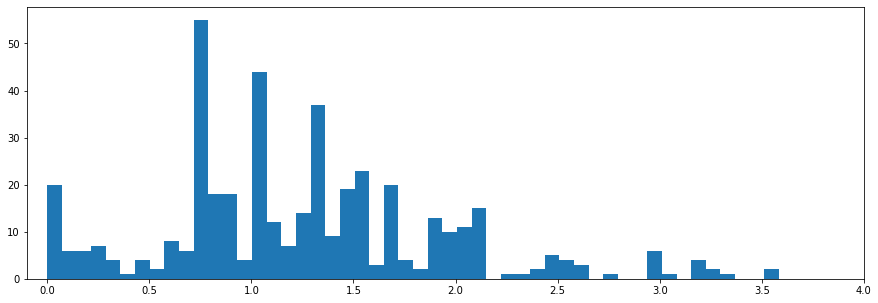

In [82]:
plt.figure(figsize=(15, 5))
plt.hist(M[np.triu_indices(M.shape[0], k=1)], bins=50)

plt.xlim(-0.1, 4)

plt.show()

In [72]:
%matplotlib inline

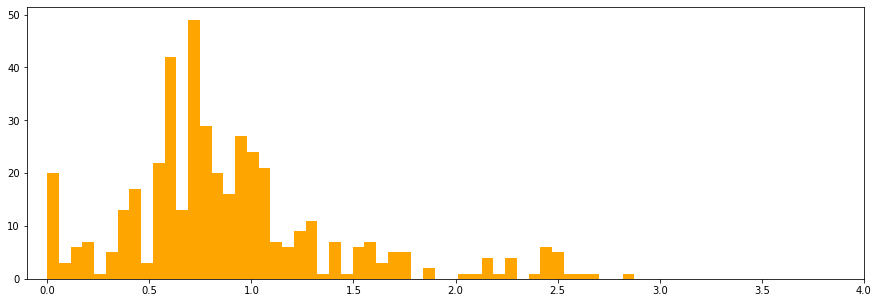

In [83]:
plt.figure(figsize=(15, 5))
plt.hist(Mp[np.triu_indices(Mp.shape[0], k=1)], bins=50, color="orange")


plt.xlim(-0.1, 4)

plt.show()

In [36]:
rec_dists = [np.linalg.norm(np.array(program_recoms[i].to_vector()) - np.array(nutritionist_recoms[i].to_vector())) 
             for i in range(len(program_recoms)) 
             if program_recoms[i] is not None]

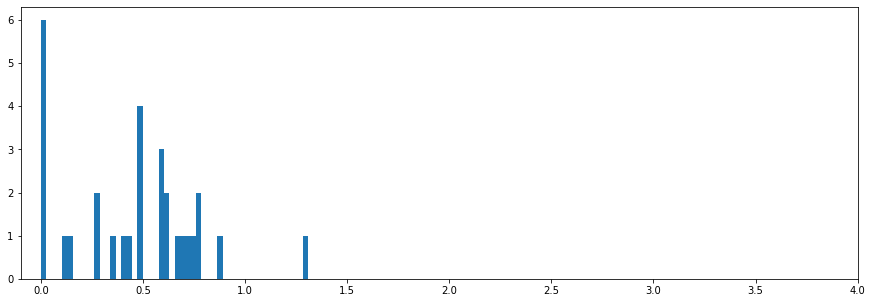

In [84]:
plt.figure(figsize=(15, 5))
plt.hist(rec_dists, bins=50)

plt.xlim(-0.1, 4)

plt.show()

In [38]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=3)

prog_pca = PCA(n_components=3)

In [48]:
vect_coords = pca.fit_transform(np.array(nutritionist_vectors))
prog_vect_coords = prog_pca.fit_transform(np.array(program_vectors))

In [49]:
%matplotlib notebook

<IPython.core.display.Javascript object>


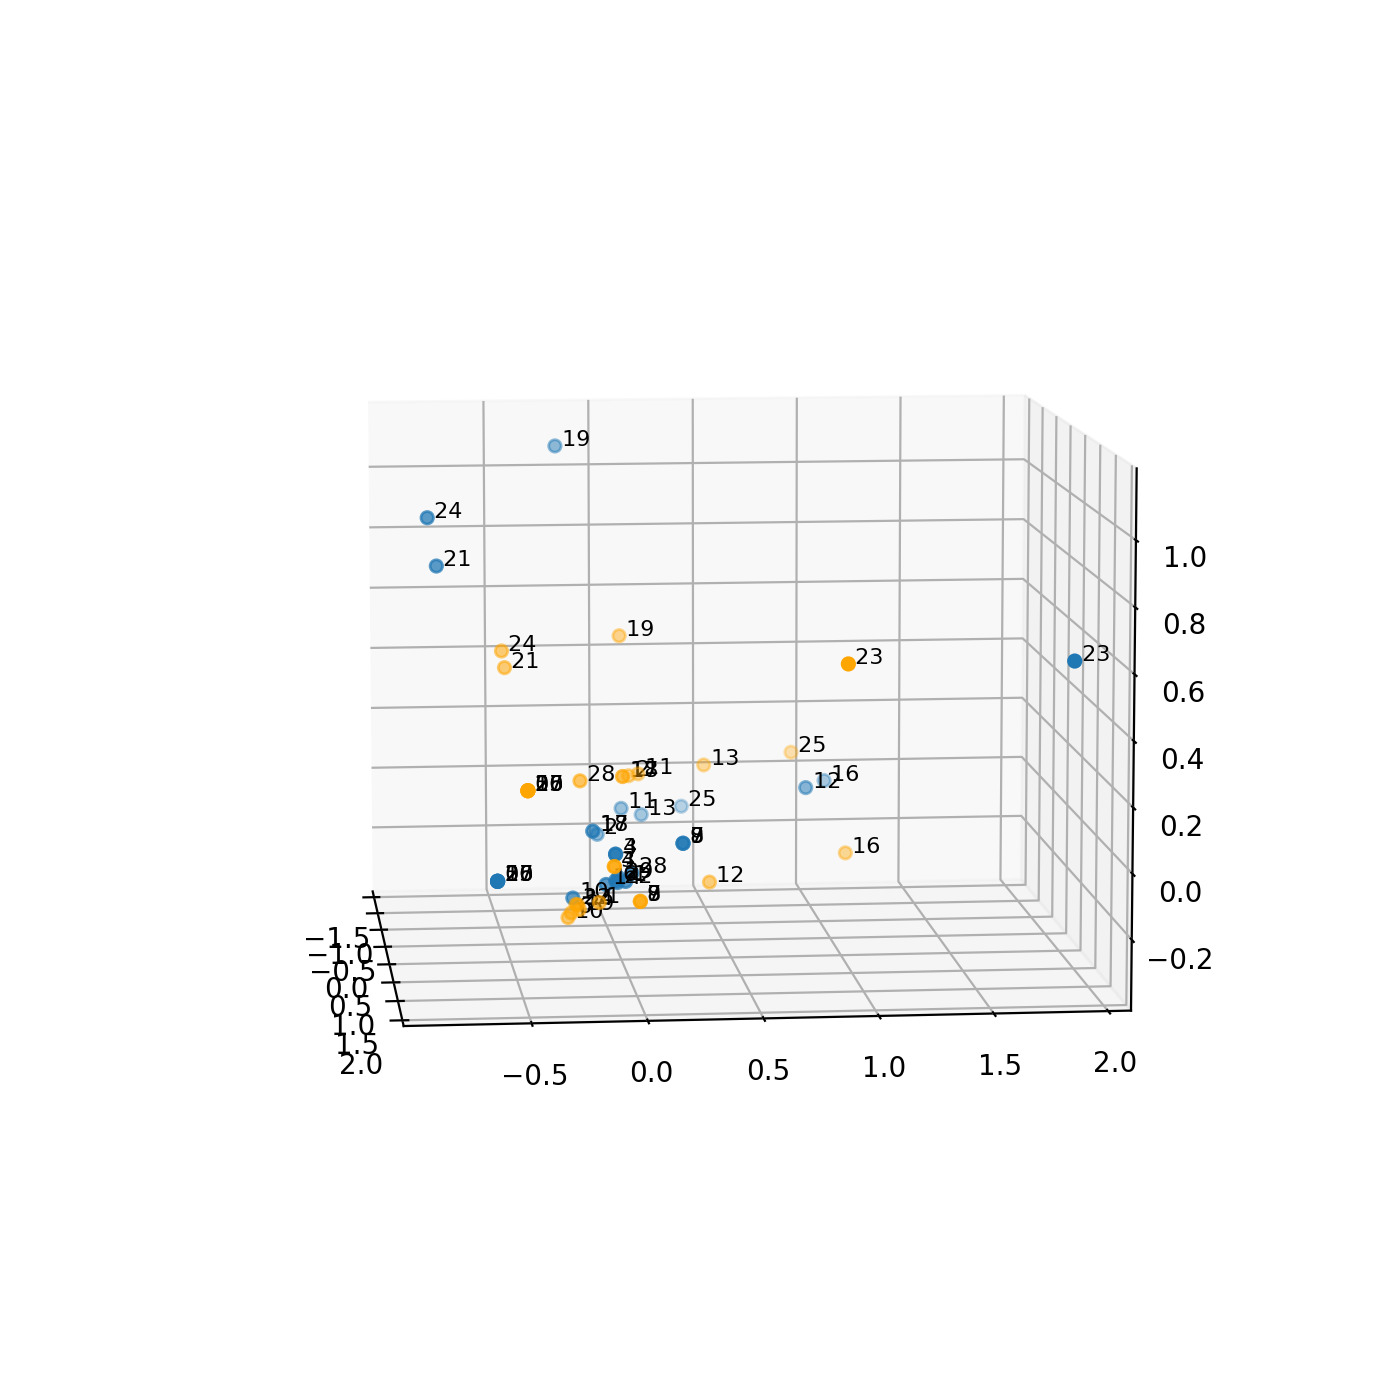

In [70]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(*vect_coords.T)
ax.scatter(*prog_vect_coords.T, c="orange")

for i in range(len(vect_coords)):
    ax.text(*vect_coords[i], " " + str(i), fontsize=8)

for i in range(len(prog_vect_coords)):
    ax.text(*prog_vect_coords[i], " " + str(i), fontsize=8)


    
plt.show()

In [60]:
nutritionist_recoms[19]._recommendations

{'ПЭП': {'nutrition': {'СМОФ Кабивен периферический': {'dose': 500.0,
    'features': {'Ккал/100мл': 70.0,
     'Белок/100мл': 3.2,
     'Жиры/100мл': 2.8,
     'Углеводы/100мл': 7.1,
     'ЦВК': 0.0,
     'Возраст': 2.0,
     'Комбинированный': 1}}},
  'demands': {'Белок_due': 1.8333333333333333,
   'Жиры_due': 2.5,
   'Углеводы_due': 7.883333333333333,
   'ККал_due': 1067.4885000000002}},
 'сипинг': {'nutrition': {},
  'demands': {'ККал': 1067.4885000000002,
   'Белок': 19.748537250000002,
   'Жиры': 58.11881833333334,
   'Углеводы': 116.35624650000001}},
 'зонд': {'nutrition': {},
  'demands': {'ККал': 1067.4885000000002,
   'Белок': 19.748537250000002,
   'Жиры': 58.11881833333334,
   'Углеводы': 116.35624650000001}}}

In [61]:
program_recoms[19]._recommendations

{'ПЭП': {'nutrition': {'Глюкоза 40%': {'dose': 60,
    'features': {'Ккал/100мл': 160.0,
     'Белок/100мл': 0.0,
     'Жиры/100мл': 0.0,
     'Углеводы/100мл': 40.0,
     'ЦВК': 1.0,
     'Возраст': 0.0,
     'Комбинированный': 0}},
   'Кабивен периферический': {'dose': 200,
    'features': {'Ккал/100мл': 71.0,
     'Белок/100мл': 2.4,
     'Жиры/100мл': 3.5,
     'Углеводы/100мл': 6.75,
     'ЦВК': 0.0,
     'Возраст': 2.0,
     'Комбинированный': 1}}},
  'demands': {'Белок_due': 1.8333333333333333,
   'Жиры_due': 2.5,
   'Углеводы_due': 7.883333333333333,
   'ККал_due': 1067.4885000000002}},
 'сипинг': {'nutrition': {}, 'demands': {}},
 'зонд': {'nutrition': {}, 'demands': {}},
 'id': 0}

In [77]:
fnames[13:16]

['00018-1683715728.3067548.json',
 '00018-1683716703.3772125.json',
 '00019-1683719999.9343734.json']

In [ ]:
{k: v for k,v in patient_info.data[0].items() if k not in ["ПЭП", "ЭП"]}["Возраст"]

In [18]:
form_patient_info

{'Дата консультации': datetime.date(2022, 5, 13),
 'ID': '00028',
 'Пол': 'Мужской',
 'Дата рождения': datetime.date(2022, 5, 13),
 'Основной диагноз': 'Низкодифференцированная нейробластома забрюшинного пространства, 4 стадия по INSS, М стадия по INRGSS [метастатическое поражение забрюшинных лимфатических узлов, костей черепа, лопаток, позвоночника, таза, конечностей, костного мозга]. MYCN негативная, del 1p, del 11q – негативная. Группа высокого риска. Терапия: Операция от 28.04.21 [биопсия образования]. Терапия по протоколу NB-2004 с 13.05.21 для пациентов группы высокого риска. Удаление нейробластомы забрюшинного пространства от 05.08.2021.',
 'Масса тела': <cancer_nutrition.utils.value.value.Value at 0x11b744c10>,
 'единицы измерения массы тела': 'кг',
 'Рост': <cancer_nutrition.utils.value.value.Value at 0x1175d09d0>,
 'единицы измерения роста': 'см',
 'Вес снижается (не набирается для <1 года)': True,
 'Активность пациента': 'активен и мобилен',
 'Пациент выглядит истощенным': F

In [ ]:
{k: v for k,v in patient_info.data[0].items() if k not in ["ПЭП", "ЭП"]}["fractions"]

In [22]:
recommendations[0]._recommendations

{'ПЭП': {'nutrition': {'Кабивен центральный': {'dose': 970,
    'features': {'Ккал/100мл': 90.0,
     'Белок/100мл': 3.4,
     'Жиры/100мл': 4.0,
     'Углеводы/100мл': 10.0,
     'ЦВК': 1.0,
     'Возраст': 2.0,
     'Комбинированный': 1}}},
  'demands': {'Белок_due': 1.5,
   'Жиры_due': 1.5,
   'Углеводы_due': 2.15,
   'ККал_due': 2445.7398000000003}},
 'сипинг': {'nutrition': {}, 'demands': {}},
 'зонд': {'nutrition': {}, 'demands': {}},
 'id': 0}

#  HERE

In [141]:
form_patient_info["Возраст"]["лет"]

15

In [38]:
out_enterals = {_type:   for _type in ["сипинг", "зонд / гастростома"] }

patient_info.data[0]["Смеси ЭП"]

{'Смесь ЭП 1': {'Название смеси для ЭП': 'Пептамен',
  'Объем смеси в сутки': 200.0,
  'Для сухих смесей: укажите разведение': 'изокалорическое',
  'Способ получения': 'сипинг'}}

In [ ]:
nutritionist_recom["сипинг"] = 

In [36]:
recom_sets[0]._recommendations["ПЭП"]["demands"]

{'Белок_due': 1.5, 'Жиры_due': 1.5, 'Углеводы_due': 4.3, 'ККал_due': 1288.7641}

In [26]:
import numpy as np

In [27]:
item = recom_sets[0]._recommendations["ПЭП"]

In [33]:
item["nutrition"]

{'Глюкоза 40%': {'dose': 40,
  'features': {'Ккал/100мл': 160.0,
   'Белок/100мл': 0.0,
   'Жиры/100мл': 0.0,
   'Углеводы/100мл': 40.0,
   'ЦВК': 1.0,
   'Возраст': 0.0,
   'Комбинированный': 0}},
 'Кабивен центральный': {'dose': 780,
  'features': {'Ккал/100мл': 90.0,
   'Белок/100мл': 3.4,
   'Жиры/100мл': 4.0,
   'Углеводы/100мл': 10.0,
   'ЦВК': 1.0,
   'Возраст': 2.0,
   'Комбинированный': 1}}}

In [28]:
values_list = []
for _, nutr in item["nutrition"].items():
    for value in sorted(list(item["demands"].keys())):
        if value == "ККал_due":
            continue
        values_list.append(nutr["features"][f"{value.split('_')[0]}/100мл"] / item["demands"][value])
values_list = np.array(values_list).reshape((-1, 3)).sum(axis=0).tolist()

In [29]:
values_list

[2.2666666666666666, 2.6666666666666665, 11.627906976744187]

# 3. Получение осмотров пациента из БД

In [30]:
def get_patient_trials(patient_inner_id):
    trial_ids = db_provider.wrapper._select(f"SELECT trial.id FROM trial LEFT JOIN patient ON trial.patient_id = patient.id WHERE patient.inner_id = '{patient_inner_id}'")
    
    out_list = []
    
    patient_info = db_provider.wrapper._select(f"SELECT * FROM. patient WHERE inner_id = '{patient_inner_id}'")
    
    for row in trial_ids:
        out_list += [get_trial_info(row[0])]
        out_list[-1]["ID"] = patient_inner_id
        out_list[-1]["Пол"] = "Мужской" if patient_info[0][2] else "Женский"
        out_list[-1]["Дата рождения"] = patient_info[0][3]
        out_list[-1]["Диагноз"] = patient_info[0][4]
        
    return out_list

In [31]:
def get_trial_info(trial_id):
    trial_info = db_provider.wrapper._select(f"SELECT trial._date, in_data_option.name, trial.therapy_stage_name, trial.therapy_stage_start_date FROM trial LEFT JOIN in_data_option ON trial.therapy_stage_id = in_data_option.id WHERE trial.id = {trial_id}")
    if len(trial_info) == 0:
        return None
    
    out_dict = dict(zip(["Дата консультации", 
                         "Этап терапии", 
                         "Название этапа терапии", 
                         "Дата начала этапа терапии"],
                        trial_info[0]))
    in_param_vals = db_provider.wrapper._select(f"SELECT in_data_item.label, trial_feature_value.value FROM trial_feature_value LEFT JOIN in_data_item ON trial_feature_value.data_item_id = in_data_item.id WHERE trial_id = {trial_id};")
    for row in in_param_vals:
        try:
            out_dict[row[0]] = float(row[1])
        except ValueError:
            out_dict[row[0]] = row[1]
    
    nutr_recommendations = db_provider.wrapper._select(f"SELECT nutrition.name, is_enteral, dose, intake_time, supply_method, dilution_method, is_software_recommendation, is_current_therapy FROM trial_nutrition_recommendation LEFT JOIN trial_recommendation_set ON rec_set_id = trial_recommendation_set.id LEFT JOIN trial ON trial_recommendation_set.trial_id = trial.id LEFT JOIN nutrition ON trial_nutrition_recommendation.nutrient_id = nutrition.id WHERE trial.id = {trial_id} ORDER BY priority;")
    
    for glob_prefix in ["", "Тек*", "Рек*"]:
        for glob_key in ["Растворы ПЭП", "Смеси ЭП"]:
            out_dict[glob_prefix + glob_key] = {}
    
    for recom in nutr_recommendations:
        if recom[-1] == recom[-2] == 0:
            # nutritionist
            glob_prefix = "Тек*"
        elif recom[-1] == 1 and recom[-2] == 0:
            # current therapy
            glob_prefix = ""
            pass
        elif recom[-2] == 1:
            # software
            glob_prefix = "Рек*"
            pass
        else:
            raise Exception("How can it be?")
        
        if recom[1] == 1:
            glob_key = glob_prefix + "Растворы ПЭП"
            loc_key = "Раствор ПЭП"
            keys = {"Название раствора для ПЭП": 0, 
                    "Объем раствора в сутки": 2, 
                    "Период проведения ПЭП": 3}
        else:
            glob_key = glob_prefix + "Смеси ЭП"
            loc_key = "Смесь ЭП"
            keys = {"Название смеси для ЭП": 0, 
                    "Объем смеси в сутки": 2, 
                    "Для сухих смесей: укажите разведение": 5, 
                    "Способ получения": 4}
        
        out_dict[glob_key][loc_key + f" {len(out_dict[glob_key]) + 1}"] = {k: recom[ind] for k,ind in keys.items()}
        
        
    # TODO: derived parameters
    
    return out_dict

In [32]:
trials = get_patient_trials("00010")

In [35]:
trial_info = PatientInfo(trials[0])

1it [00:00, 3876.44it/s]


In [42]:
NutritionRecommender(trial_info, 
                     db_provider).get_recommendations()

KeyError: 'Тяжелая белково-энергетическая недостаточность'

In [ ]:
db_provider.wrapper._select("SELECT *")